In [21]:
%matplotlib notebook

In [22]:
import numpy as np
import xtrack as xt
import matplotlib.pyplot as plt

In [23]:
line = xt.Line.from_json('pimms_02_tuned.json')

Loading line from dict:   0%|          | 0/221 [00:00<?, ?it/s]

Done loading line from dict.           


In [24]:
tw = line.twiss(method='4d')

num_particles = 5000
x_norm = np.random.normal(size=num_particles)
px_norm = np.random.normal(size=num_particles)
y_norm = np.random.normal(size=num_particles)
py_norm = np.random.normal(size=num_particles)
delta = 5e-4 * np.random.normal(size=num_particles)
particles = line.build_particles(
    weight=1e10/num_particles,
    method='4d',
    nemitt_x=1e-6, nemitt_y=1e-6,
    x_norm=x_norm, px_norm=px_norm, y_norm=y_norm, py_norm=py_norm,
    delta=delta)
tab = tw.get_normalized_coordinates(particles)

Found suitable prebuilt kernel `default_only_xtrack`.
Found suitable prebuilt kernel `only_xtrack_frozen_energy`.


In [25]:
line.discard_tracker()

class SpillExcitation:
    def __init__(self):
        self.intensity = []
        self.amplitude = 1e-6
        self.gain = 0.
        self.target_rate = 1e10/ 15000
        self.n_ave = 100
        self._i_turn = 0

        self._amplitude_log = []

    def track(self, p):
        
        self.intensity.append(np.sum(p.weight[p.state > 0]))
        self._amplitude_log.append(self.amplitude)
        
        p.px[p.state > 0] += self.amplitude * np.random.normal(size=np.sum(p.state > 0))
        
        if self._i_turn > self.n_ave:
        
            rate = (self.intensity[self._i_turn - self.n_ave] - self.intensity[self._i_turn]) / self.n_ave
            self.amplitude -= self.amplitude * self.gain * (rate - self.target_rate)/self.target_rate

        self._i_turn += 1

line.insert_element('spill_exc', SpillExcitation(), at_s=0)
import xobjects as xo
line.build_tracker(_context=xo.ContextCpu('auto'))

Compiling ContextCpu kernels...


ld: warning: -pie being ignored. It is only used when linking a main executable


Done compiling ContextCpu kernels.


In [26]:
# line.functions['fun_xsext'] = xt.FunctionPieceWiseLinear(x=[0, 0.5e-3], y=[0, 1.])
# line.vars['kse1'] = line.vv['kse1'] * line.functions['fun_xsext'](line.vars['t_turn_s'])
# line.vars['kse2'] = line.vv['kse2'] * line.functions['fun_xsext'](line.vars['t_turn_s'])

# line.functions['fun_gain'] = xt.FunctionPieceWiseLinear(x=[0, 0.25e-3, 0.5e-3], y=[0, 0, .001])
# line.vars['gain'] = line.functions['fun_gain'](line.vars['t_turn_s'])
# line.element_refs['spill_exc'].gain = line.vars['gain']

line.element_refs['spill_exc'].gain = 1e-3

line['septum'].max_x = 0.035

In [27]:
line.enable_time_dependent_vars = True
line.track(particles, num_turns=15000, with_progress=True, log_vars=('kse1', 'kse2'))

Tracking:   0%|          | 0/15000 [00:00<?, ?it/s]

Compiling ContextCpu kernels...


ld: warning: -pie being ignored. It is only used when linking a main executable


Done compiling ContextCpu kernels.


<IPython.core.display.Javascript object>


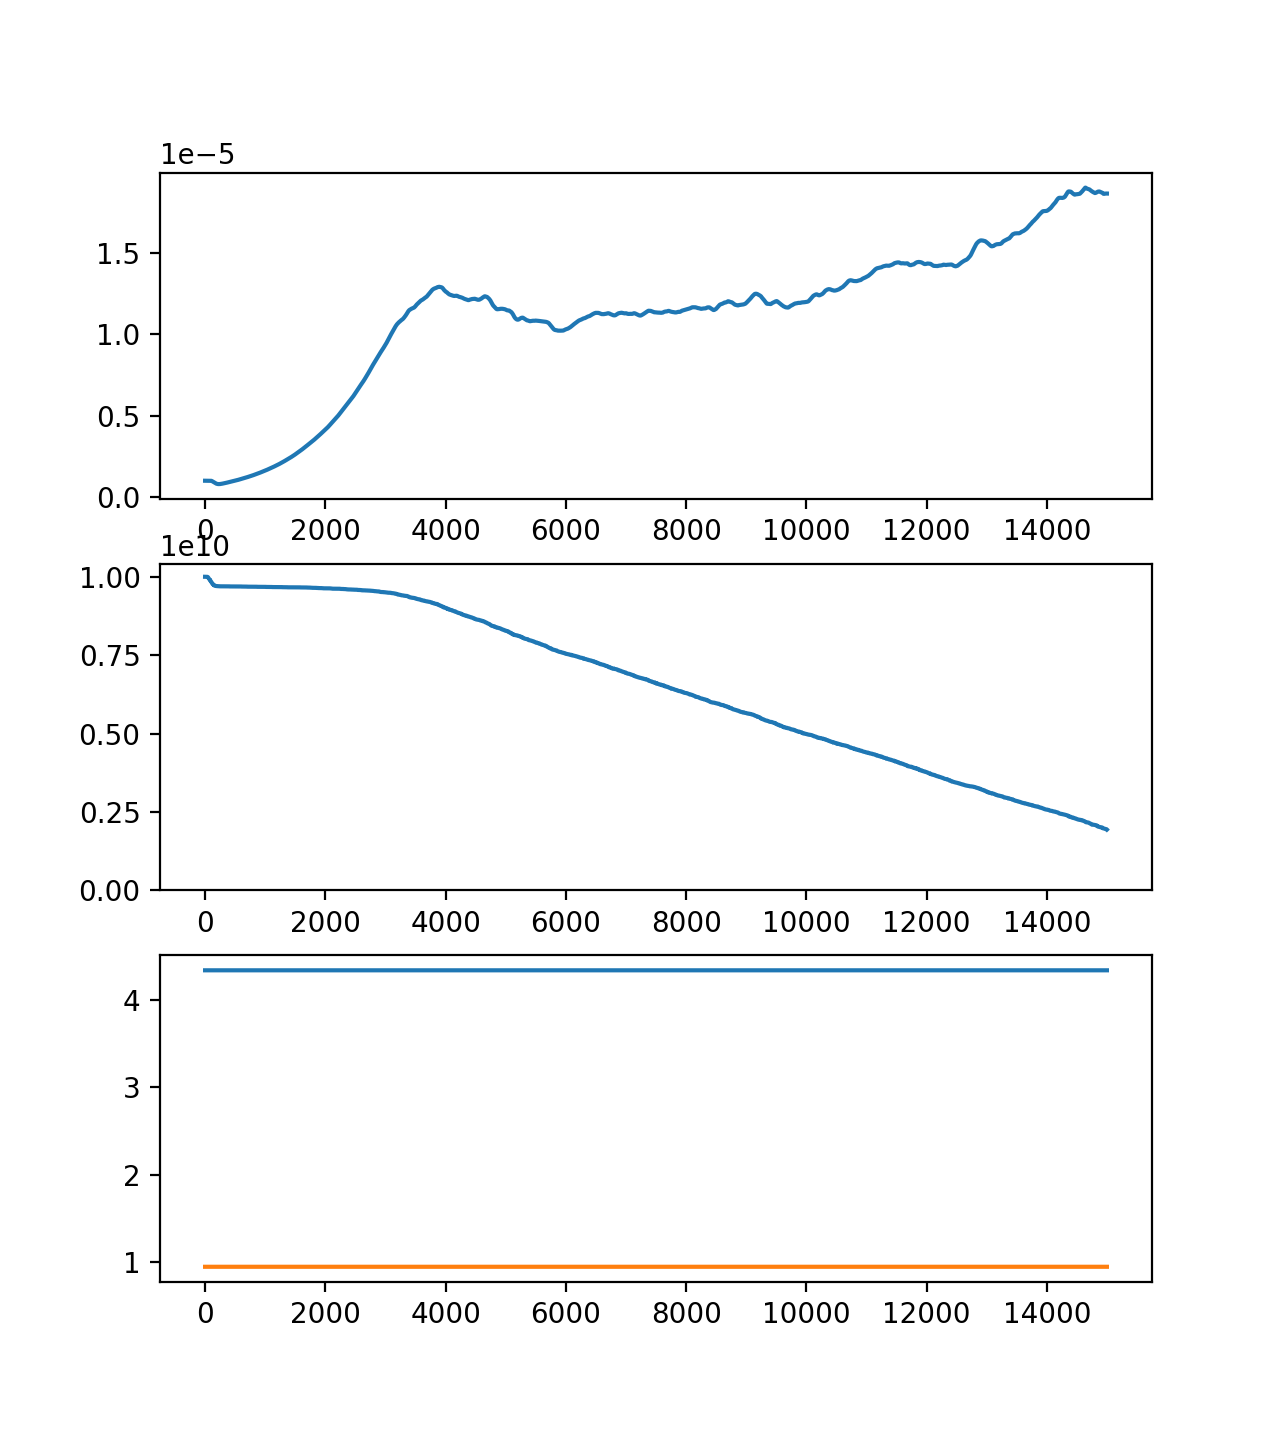

<IPython.core.display.Javascript object>


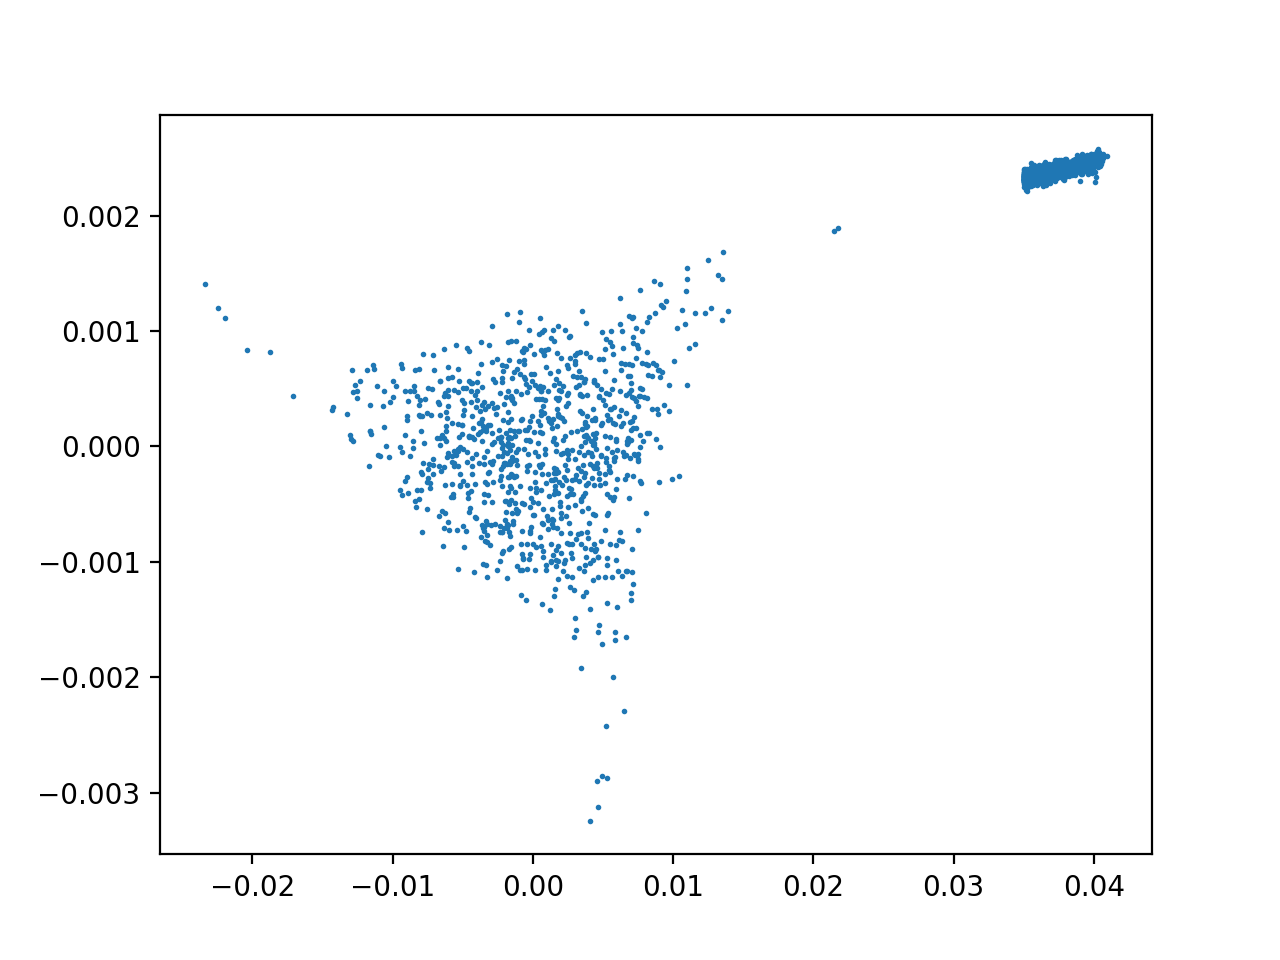

In [29]:
plt.figure(1000, figsize=(6.4, 4.8*1.5))
ax1 = plt.subplot(3,1,1)
plt.plot(line['spill_exc']._amplitude_log)

ax2 = plt.subplot(3,1,2, sharex=ax1)
plt.plot(line['spill_exc'].intensity)
plt.ylim(bottom=0)

# ax3 = plt.subplot(4,1,3, sharex=ax1)
# plt.plot(line['spill_exc']._rate_log)
# plt.axhline(line['spill_exc'].target_rate, color='grey')

ax4 = plt.subplot(3,1,3, sharex=ax1)
plt.plot(line.log_vars_last_track['kse1'])
plt.plot(line.log_vars_last_track['kse2'])

plt.figure(1001)
plt.plot(particles.x, particles.px, '.', markersize=2)
# plt.plot(x_fit_geom, px_fit_geom, 'grey')
plt.show()

In [17]:
len(line.log_vars_last_track['kse1'])

15000